 **IBM Virus Species Jump Hackathon at Deep Learning IndabaX 2019 in Durban**

Goal: Predict whether an unknown animal virus could potentially infect humans given its genome (DNA or RNA) sequence.

Importance:

Many old and new dangerous viruses infecting humans emerge from animals. Emergence of new viruses is currently considered one of the biggest existential threats facing humanity. In 1918, a world-wide flu outbreak killed over 50 million people around the world. Ebola virus is thought to have come from bats, HIV virus is thought to have come from monkeys, SARS virus potentially came from birds, and many more. We can today sequence thousands of viruses in animals but it is hard to identify which of the tens of thousands of viruses present in wild and domestic animals could potentially cross over to infect humans. Thus, a computational model to predict whether an animal virus can infect humans would be of huge importance.

Training Data: Genome sequences of 70 human viruses that can be easily transmitted from animals to humans, e.g. ebola (Class Label: Zoonotic) and sequences of another 70 viruses that cannot be easily transmitted from animals to humans (Class Label: Non-Zoonotic).

The genome sequences are basically a string of 4 characters (AGCT) and the sequence of each virus ranges from a few hundred to 230,000 characters. If you feel the training/test dataset is small, an option is to fragment each virus genome into smaller pieces which could easily create a training set of 5,000 to 10,000 samples in each class (i.e we can fragment each viral genome into 100 pieces).

Test Data: 60 Genome sequences with the class label hidden from participants but provided to hackathon organizers (30 from each class).

Evaluation: Participants will have to provide a deep learning model and their predictions for each provided test sample. Evaluation will be based on the follwing two criteria:

    Most innovative model
    Performance based on AUC/ precision-recall curves

Import all the necessary Python libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import re
from IPython.display import display
import utils

In [2]:
# latest version of xgboost crashes on fit()
!pip install xgboost==0.80  
!pip install scikit-optimize
!pip install --upgrade matplotlib

Requirement already up-to-date: matplotlib in c:\programdata\anaconda3\lib\site-packages (3.1.0)


Load the data uploaded to the current Colab instance under /content/

In [3]:
non_zoonotic = utils.loadFASTA("./content/NonZoonoticVirusesStringent0_0_GlobalViromeProject.fasta")
is_zoonotic = utils.loadFASTA("./content/ZoonoticVirusSequencesStringentGlobalViromeProject.fasta")

In [4]:
# Add target labels
non_zoonotic['Label'] = [0]*len(non_zoonotic)
is_zoonotic['Label'] = [1]*len(is_zoonotic)

# Join the two sets
data = pd.concat([non_zoonotic,is_zoonotic]).reset_index(drop=True)
display(data.head())
display(data.tail())

# Remove ambiguous nucleotides (https://reverse-complement.com/ambiguity.html)
# - as per Kameris method
def strip_ambiguous_nucleotides(seq):
    clean_seq = re.sub(r'[URYSWKMBVDHN]', '', seq)
    junk = re.findall(r"[^ACGT]+", clean_seq)
    if junk:
        warnings.warn("Unknown characters found: %s"%str(junk))
        clean_seq = re.sub(r"[^ACGT]+", "", clean_seq)
    return clean_seq
data['Sequence'] = data['Sequence'].apply(strip_ambiguous_nucleotides)

# Check for any null values
print("Nulls:")
print(data.isnull().sum())
print(data.applymap(lambda x: x == '').sum())

,ID,Description,Sequence,Label
0,NC_028246.1,"Adelaide River virus isolate DPP61, complete g...",ACGGAGAAAAACAAAAAAACTATAGTGATTAGATAAATAAGGAAAA...,0
1,NC_006152.1,"Adeno-associated virus 5, complete genome",CTCTCCCCCCTGTCGCGTTCGCTCGCTCGCTGGCTCGTTTGGGGGG...,0
2,NC_010820.1,"Simian foamy virus 3, complete genome",TGTGGCTGATATCCACTAAAATAGTAGGCCCCCAGGAAAAGGATTA...,0
3,NC_005996.1,"African horsesickness virus segment 2, complet...",GTTAAATTCACCATGGCTTCCGAATTTGGCATTTTGATTTGTGATA...,0
4,NC_006021.1,"African horsesickness virus segment 1, complet...",GTTTATTTGAGCGATGGTCATCACCGTGCAAGGTGCAGATCTAGTC...,0


,ID,Description,Sequence,Label
196,NC_003310.1,"Monkeypox virus Zaire-96-I-16, complete genome",GTTAGTAAATTATATACATAATTTTATAATTAATTTAATTTTACTA...,1
197,NC_002728.1,"Nipah virus, complete genome",ACCAAACAAGGGAGAATATGGATACGTTAAAATATATAACGTATTT...,1
198,NC_005062.1,"Omsk hemorrhagic fever virus, complete genome",AGATTTTCTTGCACGTGCGTGCGCTTGCTTCAGACAGCAATAGCAG...,1
199,NC_005336.1,"Orf virus, complete genome",TCGCGGACCAGGAGTTCCTGCGGGAGGAGTTACAGCGGAGGCTGGA...,1
200,NC_006430.1,"Parainfluenza virus 5, complete genome",ACCAAGGGGAAAATGAAGTGGTGACTCAAATCATCGAAGACCCTCG...,1


Nulls:
ID             0
Description    0
Sequence       0
Label          0
dtype: int64
ID             0
Description    0
Sequence       0
Label          0
dtype: int64


In [5]:
# Remove unnecessary columns 
clean_data = data.drop(['ID', 'Description'],1)
display(clean_data.head())

,Sequence,Label
0,ACGGAGAAAAACAAAAAAACTATAGTGATTAGATAAATAAGGAAAA...,0
1,CTCTCCCCCCTGTCGCGTTCGCTCGCTCGCTGGCTCGTTTGGGGGG...,0
2,TGTGGCTGATATCCACTAAAATAGTAGGCCCCCAGGAAAAGGATTA...,0
3,GTTAAATTCACCATGGCTTCCGAATTTGGCATTTTGATTTGTGATA...,0
4,GTTTATTTGAGCGATGGTCATCACCGTGCAAGGTGCAGATCTAGTC...,0


# **This is where your model starts. Train your model on clean_data dataframe and predict classes for clean_test dataframe**

Examine sequence lengths of the two classes. Zoonotic viruses in this dataset tend to be somehwat shorter but the distributions are fairly similar overall, i.e. length is not a very useful feature.

Sequence lengths

    Zoonotic: avg - 19144, min - 675, max - 224499
Non-Zoonotic: avg - 33503, min - 758, max - 233501


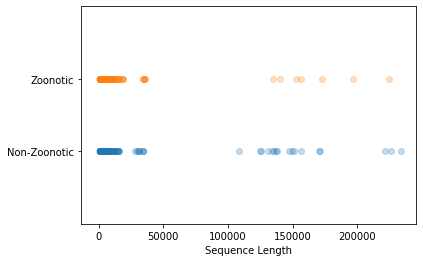

In [6]:
lens_zoo = []
lens_nonzoo = []
for x in non_zoonotic['Sequence']:
    lens_nonzoo.append(len(x))
for x in is_zoonotic['Sequence']:
    lens_zoo.append(len(x))
print("Sequence lengths\n")
print("    Zoonotic: avg - %.0f, min - %d, max - %d"%(np.mean(lens_zoo),min(lens_zoo),max(lens_zoo)))
print("Non-Zoonotic: avg - %.0f, min - %d, max - %d"%(np.mean(lens_nonzoo),min(lens_nonzoo),max(lens_nonzoo)))
plt.scatter(lens_nonzoo,[0]*len(lens_nonzoo),alpha=0.25)
plt.scatter(lens_zoo,[1]*len(lens_zoo),alpha=0.25)
axes = plt.gca()
axes.set_ylim([-1,2])
axes.set_yticks([0,1])
axes.set_yticklabels(["Non-Zoonotic","Zoonotic"])
axes.set_xlabel("Sequence Length")
plt.show()

In [83]:
import numpy as np
def kmer_dictionary(k=3, alphabet="ACGT"):
    """Generates a dictionary of permurations of the alphabet up to length k.
    
    Returns the dictionary of k-mers with the value as the position generated (for easy vector indexing).
    E.g. kmer_dictionary(2) -> {"AA":0,
                                "AC":1,
                                "AG":2,
                                "AT":3,
                                "CA":4,
                                "CC":5,
                                "CG":6,
                                "CT":7,
                                "GA":8,
                                "GC":9,
                                "GG":10,
                                "GT":11,
                                "TA":12,
                                "TC":13,
                                "TG":14,
                                "TT":15}
    """
    global counter
    counter = 0
    def kmer_helper(dictionary, k, n, word):
        global counter
        if k == 0:
            dictionary[word] = counter
            counter += 1
        else:
            for i in range(n):
                kmer_helper(dictionary, k-1, n, word+alphabet[i])
              
    dictionary = {}
    kmer_helper(dictionary, k, len(alphabet), "")
    return dictionary
    
def kmer_features(seq, k, kmer_dict):
    """Calculate the normalised k-mer frequencies for a sequence.
    
    Note that the features wrap around.
    E.g. kmer_features("ACGTA", 2, kmer_dictionary(2)) -> array([0.2,0.2,0,0,0,0,0,0,0,0,0,0.2,0.2,0,0,0])
    """
    n = len(seq)
    features = np.zeros(len(kmer_dict))
    # calculate overlapping k-mers
    for i in range(n):
        if (i+k) <= n:
           subseq = seq[i:i+k]
        else:
            # wrap around -> no assumption of alignment
            subseq = seq[i:n]+seq[:i+k-n]
        if subseq in kmer_dict:
            features[kmer_dict.get(subseq)] += 1
        else:
            raise Exception("'%s' not in k-mer dictionary!"%subseq)
    # normalise vector
    if features.sum() > 0:
        features /= features.sum()
    return features

In [84]:
k = 2
kmer_dict = kmer_dictionary(k)
kmer_feat = kmer_features("ACGTA", k, kmer_dict)
display(kmer_dict)
display(kmer_feat)

{'AA': 0,
 'AC': 1,
 'AG': 2,
 'AT': 3,
 'CA': 4,
 'CC': 5,
 'CG': 6,
 'CT': 7,
 'GA': 8,
 'GC': 9,
 'GG': 10,
 'GT': 11,
 'TA': 12,
 'TC': 13,
 'TG': 14,
 'TT': 15}

array([0.2, 0.2, 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0.2, 0.2,
       0. , 0. , 0. ])

In [85]:
y = np.array(data['Label'])

# Kameris feature extraction method
# Step 1: calculate k-mer features
k = 3
kmer_dict = kmer_dictionary(k)
features = []
for x in data['Sequence']:
    kmer_feat = kmer_features(x, k, kmer_dict)
    features.append(kmer_feat)
X = np.array(features)

# # Step 2: normalise variance to 1
# X = (X - X.mean(axis=0)) / X.std(axis=0)

# # Step 3: truncated SVD to 10% of average number of non-zero features
# from sklearn.decomposition import TruncatedSVD
# ave_nonzero = np.mean(np.count_nonzero(X, axis=1))
# n_components = int(ave_nonzero//10) 
# print(n_components)
# svd = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42)
# svd.fit(X)
# #print(svd.explained_variance_ratio_)
# print(svd.explained_variance_ratio_.sum())
# #print(svd.singular_values_)
# X = svd.transform(X)

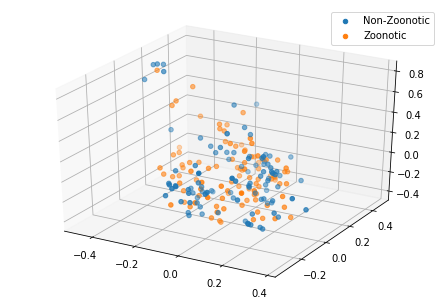

In [86]:
# Visualise data - Measure of Distance Map (MoDMap)
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from mpl_toolkits.mplot3d import Axes3D

# MultiDimensional Scaling (MDS) with Manhattan pairwise distances (as per Kameris)
D = pairwise_distances(X, metric="manhattan", n_jobs=3)
embedding = MDS(n_components=3, dissimilarity="precomputed", random_state=42)
vizData = embedding.fit_transform(D)

# Plot
fig = plt.figure()
ax = Axes3D(fig)
vizDataNonZoo = vizData[y==0,:]
vizDataZoo = vizData[y==1, :]
ax.scatter(vizDataNonZoo[:,0],vizDataNonZoo[:,1],vizDataNonZoo[:,2], label="Non-Zoonotic")
ax.scatter(vizDataZoo[:,0],vizDataZoo[:,1],vizDataZoo[:,2], label="Zoonotic")
ax.legend()
plt.show();

In [87]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import skopt

# ignore deprecation warnings
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

    test_acc = 0
    rep = 100
    test_accs = []
    for i in range(rep):
      #X, y = shuffle(X, y)
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

      clf = XGBClassifier(max_depth=5, min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0)#, n_estimators=50)#, learning_rate=0.1, n_estimators=100)
      #OPTS = {'colsample_bylevel': 0.9941792343076375, 'colsample_bytree': 0.9980911811509141, 'gamma': 0.18162429124874818, 'learning_rate': 0.031154104244716686, 'max_delta_step': 20, 'max_depth': 20, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 1e-09, 'reg_lambda': 1e-09, 'scale_pos_weight': 25.562818573142966, 'subsample': 1.0}
      #OPTS = {'colsample_bylevel': 0.995184389043852, 'colsample_bytree': 1.0, 'gamma': 1e-09, 'learning_rate': 0.10700078793558986, 'max_delta_step': 3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 51, 'reg_alpha': 1.0, 'reg_lambda': 3.8027472200512804, 'scale_pos_weight': 10.438008233212393, 'subsample': 0.525545725010262}
#       OPTS = {'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0008443636585505011, 'learning_rate': 0.6387529414322168, 'max_delta_step': 19, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 69, 'reg_alpha': 0.0038101465339447096, 'reg_lambda': 8.216105644283349e-09, 'scale_pos_weight': 499.99999999999994, 'subsample': 0.6611537932251126}
      #clf = XGBClassifier(**OPTS)
#       clf = XGBClassifier(
#             n_jobs = 1,
#             booster='dart',
#             objective = 'binary:logistic',
#             eval_metric = 'auc',
#             silent=1,
#             **OPTS)
      clf.fit(X_train, y_train)
      pred = clf.predict(X_train)
      accuracy = (y_train==pred).sum() / len(y_train)

      pred = clf.predict(X_test)
      accuracy = (y_test==pred).sum() / len(y_test)
      test_accs.append(accuracy)
    test_accs = np.array(test_accs)
    print("Test Accuracy: %.4f +/- %.4f"%(test_accs.mean(),test_accs.std()))
    print("Min: %.4f, Max: %.4f"%(test_accs.min(),test_accs.max()))

Test Accuracy: 0.6359 +/- 0.0633
Min: 0.4878, Max: 0.7805


Train Accuracy: 0.9900
[[ 99   1]
 [  1 100]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


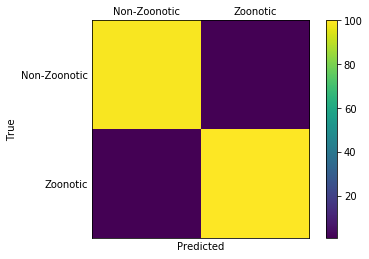

In [88]:
clf = XGBClassifier(max_depth=5,min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0)
clf.fit(X, y)
pred = clf.predict(X)
train_accuracy = (y==pred).sum() / len(y)
print("Train Accuracy: %.4f"%train_accuracy)

from sklearn.metrics import confusion_matrix
labels = ['Non-Zoonotic', 'Zoonotic']
cm = confusion_matrix(y, pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [90]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

# Source: https://www.kaggle.com/nanomathias/bayesian-optimization-of-xgboost-lb-0-9769

ITERATIONS = 100 # 1000

# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = XGBClassifier(
        n_jobs = 1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
#         tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (1, 10), #(0, 10),
        'max_depth': (1, 25),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        #'colsample_bytree': (0.99, 1.0, 'uniform'),
        #'colsample_bylevel': (0.99, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'n_estimators': (20, 100),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    #clf_name = bayes_cv_tuner.estimator.__class__.__name__
    #all_models.to_csv(clf_name+"_cv_results.csv")
    
result = bayes_cv_tuner.fit(X, y, callback=status_print)

Model #1
Best ROC-AUC: 0.5
Best params: {'colsample_bylevel': 0.4160029192647807, 'colsample_bytree': 0.7304484857455519, 'gamma': 0.13031389926541354, 'learning_rate': 0.042815319280763466, 'max_delta_step': 13, 'max_depth': 11, 'min_child_weight': 4, 'n_estimators': 79, 'reg_alpha': 5.497557739289786e-07, 'reg_lambda': 0.05936070635912049, 'scale_pos_weight': 0.060830282487222144, 'subsample': 0.13556548021189216}

Model #2
Best ROC-AUC: 0.57
Best params: {'colsample_bylevel': 0.8390144719977516, 'colsample_bytree': 0.8844821246070537, 'gamma': 4.358684608480795e-07, 'learning_rate': 0.7988179462781242, 'max_delta_step': 17, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 48, 'reg_alpha': 0.0005266983003701547, 'reg_lambda': 276.5424475574225, 'scale_pos_weight': 0.3016410771843142, 'subsample': 0.9923710598637134}

Model #3
Best ROC-AUC: 0.6723
Best params: {'colsample_bylevel': 0.4503841871781403, 'colsample_bytree': 0.9195352964526833, 'gamma': 8.168958221061441e-09, 'learn

Model #21
Best ROC-AUC: 0.7114
Best params: {'colsample_bylevel': 1.0, 'colsample_bytree': 0.6022671910312741, 'gamma': 6.640433354156604e-07, 'learning_rate': 0.5864318599641974, 'max_delta_step': 18, 'max_depth': 12, 'min_child_weight': 8, 'n_estimators': 59, 'reg_alpha': 1e-09, 'reg_lambda': 2.1695888003744552, 'scale_pos_weight': 499.99999999999994, 'subsample': 0.6513318446061033}

Model #22
Best ROC-AUC: 0.7114
Best params: {'colsample_bylevel': 1.0, 'colsample_bytree': 0.6022671910312741, 'gamma': 6.640433354156604e-07, 'learning_rate': 0.5864318599641974, 'max_delta_step': 18, 'max_depth': 12, 'min_child_weight': 8, 'n_estimators': 59, 'reg_alpha': 1e-09, 'reg_lambda': 2.1695888003744552, 'scale_pos_weight': 499.99999999999994, 'subsample': 0.6513318446061033}

Model #23
Best ROC-AUC: 0.7114
Best params: {'colsample_bylevel': 1.0, 'colsample_bytree': 0.6022671910312741, 'gamma': 6.640433354156604e-07, 'learning_rate': 0.5864318599641974, 'max_delta_step': 18, 'max_depth': 12, '

Model #42
Best ROC-AUC: 0.7332
Best params: {'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0008443636585505011, 'learning_rate': 0.6387529414322168, 'max_delta_step': 19, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 69, 'reg_alpha': 0.0038101465339447096, 'reg_lambda': 8.216105644283349e-09, 'scale_pos_weight': 499.99999999999994, 'subsample': 0.6611537932251126}

Model #43
Best ROC-AUC: 0.7332
Best params: {'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0008443636585505011, 'learning_rate': 0.6387529414322168, 'max_delta_step': 19, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 69, 'reg_alpha': 0.0038101465339447096, 'reg_lambda': 8.216105644283349e-09, 'scale_pos_weight': 499.99999999999994, 'subsample': 0.6611537932251126}

Model #44
Best ROC-AUC: 0.7332
Best params: {'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0008443636585505011, 'learning_rate': 0.6387529414322168, 'max_delta_step': 19, 'max_depth': 7, 'min_child_

Model #63
Best ROC-AUC: 0.7332
Best params: {'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0008443636585505011, 'learning_rate': 0.6387529414322168, 'max_delta_step': 19, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 69, 'reg_alpha': 0.0038101465339447096, 'reg_lambda': 8.216105644283349e-09, 'scale_pos_weight': 499.99999999999994, 'subsample': 0.6611537932251126}

Model #64
Best ROC-AUC: 0.7332
Best params: {'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0008443636585505011, 'learning_rate': 0.6387529414322168, 'max_delta_step': 19, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 69, 'reg_alpha': 0.0038101465339447096, 'reg_lambda': 8.216105644283349e-09, 'scale_pos_weight': 499.99999999999994, 'subsample': 0.6611537932251126}

Model #65
Best ROC-AUC: 0.7332
Best params: {'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0008443636585505011, 'learning_rate': 0.6387529414322168, 'max_delta_step': 19, 'max_depth': 7, 'min_child_

Model #84
Best ROC-AUC: 0.7332
Best params: {'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0008443636585505011, 'learning_rate': 0.6387529414322168, 'max_delta_step': 19, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 69, 'reg_alpha': 0.0038101465339447096, 'reg_lambda': 8.216105644283349e-09, 'scale_pos_weight': 499.99999999999994, 'subsample': 0.6611537932251126}

Model #85
Best ROC-AUC: 0.7332
Best params: {'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0008443636585505011, 'learning_rate': 0.6387529414322168, 'max_delta_step': 19, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 69, 'reg_alpha': 0.0038101465339447096, 'reg_lambda': 8.216105644283349e-09, 'scale_pos_weight': 499.99999999999994, 'subsample': 0.6611537932251126}

Model #86
Best ROC-AUC: 0.7332
Best params: {'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.0008443636585505011, 'learning_rate': 0.6387529414322168, 'max_delta_step': 19, 'max_depth': 7, 'min_child_